In [1]:
%matplotlib inline

In [2]:
import numpy as onp
import jax.numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from scipy.signal.windows import dpss
#from scipy.linalg import expm

In [3]:
from qiskit.pulse.library import Gaussian, Drag
from qiskit.test.mock import FakeValencia, FakeArmonk
from qiskit import pulse

In [4]:
from CDL_utils import su_3_basis

In [5]:
from jax.scipy.linalg import expm
from jax import vmap, lax, jit

$$\large{
\frac{\hat{H}^{R}}{\hbar}=\Delta|2\rangle\langle 2|+\frac{{\Omega}_{x}(t)}{2} \sum_{j=1}^{2} \hat{\sigma}_{j, j-1}^{x}+\frac{{\Omega}_{y}(t)}{2} \sum_{j=1}^{2} \hat{\sigma}_{j, j-1}^{y}}
$$

### where

$$\large{
\hat{\sigma}_{j, j-1}^{x}=\sqrt{j}(|j\rangle\langle j-1|+| j-1\rangle\langle j|)}
$$

$$\large{
\hat{\sigma}_{j, j-1}^{y}=i \sqrt{j}(|j\rangle\langle j-1|-| j-1\rangle\langle j|)}
$$

Ref: Motzoi, F., Gambetta, J. M., Rebentrost, P., & Wilhelm, F. K. (2009). Simple pulses for elimination of leakage in weakly nonlinear qubits. Physical review letters, 103(11), 110501.

In [6]:
su_3_unitary = expm(-1j*su_3_basis()[5])
su_3_unitary.dot(su_3_unitary.T.conj())

TARGET = expm(-1j*su_3_basis()[5])

In [7]:
# projector:  |1><0|
P_10 = np.array(
    [[0.+0.j, 0.+0.j, 0.+0.j],
    [1.+0.j, 0.+0.j, 0.+0.j],
    [0.+0.j, 0.+0.j, 0.+0.j]])

# projector: |0><1|
P_01 = np.array(
    [[0.+0.j, 1.+0.j, 0.+0.j],
     [0.+0.j, 0.+0.j, 0.+0.j],
     [0.+0.j, 0.+0.j, 0.+0.j]])

In [8]:
# projector: |2><1|
P_21 = np.array(
      [[0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j]])

# projector: |1><2|
P_12 = np.array(
       [[0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j]])

# projector: |2><2|
P_22 = np.array(
       [[0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j]])

In [9]:
sigma_x_10 = P_10 + P_01
sigma_x_21 = P_21 + P_12

sigma_y_10 = 1j*P_10 - 1j*P_01
sigma_y_21 = 1j*P_21 - 1j*P_12

In [10]:
backend = FakeArmonk()
#print(backend.configuration().hamiltonian.keys())
#print(backend.configuration().hamiltonian['description'])
device_frequencies= backend.configuration().hamiltonian['vars']
print(device_frequencies)

{'delta0': -2181477525.8495026, 'omegad0': 116220622.89875916, 'wq0': 31239072791.693638}


In [11]:
# from IBMQ Armonk calibration data
anharmonicity = -2.*np.pi*0.34719
anharmonicity*1e9 #GHz 

-2181459106.79968

In [12]:
# qutrit sigma_x control 
X_control = 0.5*sigma_x_10 + 0.5*np.sqrt(2)*sigma_x_21

# qutrit sigma_y control 
Y_control = 0.5*sigma_y_10 + 0.5*np.sqrt(2)*sigma_y_21

control_ops = np.array([X_control,Y_control])

# leakage operator (always on)
drift = anharmonicity*P_22

### Initial Slepian (DPSS) controls pulses 

In [110]:
N = 256
W = 0.025
num_basis_functions = 8

# pulse duration 
tau = 1.

# pixel width
dt = tau/N #0.22222 ns

# Slepians
V = np.array(dpss(N,N*W,num_basis_functions).T)

# random coefficients
alpha_init  = onp.random.rand(V.shape[1],2)

# Initial controls
Omega = V.dot(alpha_init)

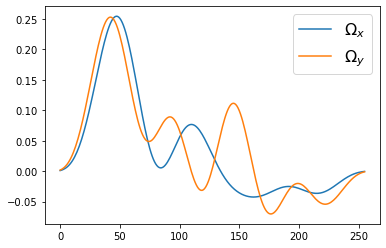

In [111]:
plt.plot(Omega[:,0], label='$\Omega_x$');
plt.plot(Omega[:,1], label='$\Omega_y$');

plt.legend(fontsize=16);

In [112]:
@jit
def U_t(alpha):
    #update controls
    Omega = V.dot(alpha)
    
    #update controlled Hamiltonian
    H_Omega = np.tensordot(Omega,control_ops,1)
    H_t = drift + H_Omega
    
    #compute time-slot propagators
    U_t = np.flip(vmap(expm)(-1j*dt*H_t), axis=0)
    return U_t

@jit
def U_final(U_t):
    def ddot(carry, in_array):
        return (np.matmul(carry,in_array), carry)
    return lax.scan(ddot, np.eye(3).astype(np.complex64), U_t)[0]


### First order gradient of exponential

$$
\large{\frac{\partial U_T}{\partial \Omega_{j}} \approx-i \Delta t H_{j} e^{-i \Delta t H_{t}}}
$$

In [113]:
def partial_U_t(UU):
    return np.array([np.matmul(-1j*dt*X_control,UU), np.matmul(-1j*dt*Y_control,UU)])

In [114]:
def partial_U_T(alpha):
    
    partial_X = [] 
    partial_Y = [] 
    
    Omega = V.dot(alpha)
    H_Omega = onp.tensordot(Omega,control_ops,1)
    H_t = drift + H_Omega

    UU = U_t(alpha)
    dUUdt = partial_U_t(UU)
    
    U_k_to_0 = np.eye(3)
    U_n_to_k = U_final(UU)
    
    for k in range(N-1,-1,-1):
        # 'remove' UU(k) from product by post-multiplying by 
        U_n_to_k = U_n_to_k.dot(UU[k].T.conj())
        partial_X.append(np.dot(U_n_to_k, dUUdt[0,k]).dot(U_k_to_0))
        partial_Y.append(np.dot(U_n_to_k, dUUdt[1,k]).dot(U_k_to_0))

        # add UU(k) to U_k_to_0
        U_k_to_0 = UU[k].dot(U_k_to_0)
    
    return np.array([partial_X, partial_Y])

In [115]:
pp = partial_U_T(alpha_init)

In [116]:
def loss_phase_inv(alpha_ravel):
    alpha = alpha_ravel.reshape(alpha_init.shape, order='F')
    U_f = U_final(U_t(alpha))
    return 1. - (1./3.)*np.abs(np.trace(TARGET.T.conj().dot(U_f)))

def loss_phase_inv_onp(alpha_ravel):
    return onp.array(loss_phase_inv(alpha_ravel),dtype=onp.float64)

def grad_loss_phase_inv(alpha_ravel):
    alpha = alpha_ravel.reshape(alpha_init.shape, order='F')
    U_f = U_final(U_t(alpha))
    fid = np.trace(TARGET.T.conj().dot(U_f))

    partial_alpha = np.tensordot(V,partial_U_T(alpha), [[0],[1]])
    grad_alpha = (-1./3.)*np.real(np.exp(-1j * np.angle(fid))*np.trace(np.matmul(TARGET.T.conj(),partial_alpha), axis1=2, axis2=3)) 
    return grad_alpha.ravel(order='F')

def grad_loss_phase_inv_onp(alpha_ravel):
    return onp.array(grad_loss(alpha_ravel), dtype=onp.float64)

def loss(alpha_ravel):
    alpha = alpha_ravel.reshape(alpha_init.shape, order='F')
    U_f = U_final(U_t(alpha))
    return 1. - (1./3.)*np.real(np.trace(TARGET.T.conj().dot(U_f)))

def loss_onp(alpha_ravel):
    return onp.array(loss(alpha_ravel),dtype=onp.float64)

In [117]:
def grad_loss(alpha_ravel):
    alpha = alpha_ravel.reshape(alpha_init.shape, order='F')
    partial_alpha = np.tensordot(V,partial_U_T(alpha), [[0],[1]])
    grad_alpha = (-1./3.)*np.real(np.trace(np.matmul(TARGET.T.conj(),partial_alpha), axis1=2, axis2=3)) 
    return grad_alpha.ravel(order='F')

def grad_loss_onp(alpha_ravel):
    return onp.array(grad_loss(alpha_ravel), dtype=onp.float64)

In [118]:
opt.check_grad(loss_phase_inv_onp, grad_loss_phase_inv_onp, alpha_init.ravel(order='F'))
#opt.check_grad(loss_onp, grad_loss_onp, alpha_init.ravel(order='F'))

0.010131614739382193

In [86]:
TOL=1e-12
GTOL=1e-12
max_iters=500
opt_trust_region = {'maxiter':max_iters,
                    'verbose':2,'gtol':GTOL,
                    'xtol':TOL}

In [87]:
# jit compilation ... may take a bit
loss(alpha_init.ravel())

DeviceArray(0.8688947, dtype=float32)

In [88]:
TARGET = expm(-1j*su_3_basis()[5])
print(TARGET)

[[1.        -0.j         0.        -0.j         0.        -0.j        ]
 [0.        -0.j         0.5403023 +0.j         0.        -0.84147096j]
 [0.        +0.j         0.        -0.8414711j  0.54030234+0.j        ]]


In [ ]:
rez = opt.minimize(loss_phase_inv_onp, 
                   alpha_init.ravel(order='F'),
                   jac=grad_loss_phase_inv_onp, hess='2-point',
                   method='trust-constr',
                   #constraints=[], # add constraint so that max Omega < 1 for IBM AWG
                   options=opt_trust_region,
                   bounds=None)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   1   |   0   | +5.6626e-01 | 1.00e+00 | 6.62e-03 | 0.00e+00 |
|   2   |   2   |   1   | +5.5005e-01 | 7.00e+00 | 6.28e-03 | 0.00e+00 |
|   3   |   3   |   3   | +4.3967e-01 | 4.90e+01 | 3.81e-03 | 0.00e+00 |
|   4   |   4   |   4   | +4.2059e-01 | 4.90e+01 | 9.15e-03 | 0.00e+00 |
|   5   |   5   |   5   | +4.2059e-01 | 2.45e+01 | 9.15e-03 | 0.00e+00 |
|   6   |   6   |   6   | +1.0155e-01 | 1.72e+02 | 1.05e-03 | 0.00e+00 |
|   7   |   7   |   7   | +1.0155e-01 | 5.90e+01 | 1.05e-03 | 0.00e+00 |
|   8   |   8   |   8   | +1.0155e-01 | 5.90e+00 | 1.05e-03 | 0.00e+00 |
|   9   |   9   |   9   | +1.0155e-01 | 2.95e+00 | 1.05e-03 | 0.00e+00 |
|  10   |  10   |  10   | +9.9821e-02 | 5.90e+00 | 6.08e-04 | 0.00e+00 |
|  11   |  11   |  12   | +9.9821e-02 | 2.06e+00 | 6.08e-04 | 0.00e+00 |
|  12   |  12   |  14   | +9.9307e-02 | 1.44e+01 | 

|  112  |  112  |  125  | +8.6067e-02 | 5.44e-01 | 1.33e-04 | 0.00e+00 |
|  113  |  113  |  126  | +8.6015e-02 | 5.44e-01 | 1.67e-04 | 0.00e+00 |
|  114  |  114  |  127  | +8.5966e-02 | 5.44e-01 | 1.33e-04 | 0.00e+00 |
|  115  |  115  |  128  | +8.5916e-02 | 5.44e-01 | 1.68e-04 | 0.00e+00 |
|  116  |  116  |  129  | +8.5869e-02 | 5.44e-01 | 1.33e-04 | 0.00e+00 |
|  117  |  117  |  130  | +8.5820e-02 | 5.44e-01 | 1.69e-04 | 0.00e+00 |
|  118  |  118  |  131  | +8.5777e-02 | 5.44e-01 | 1.33e-04 | 0.00e+00 |
|  119  |  119  |  132  | +8.5729e-02 | 5.44e-01 | 1.69e-04 | 0.00e+00 |
|  120  |  120  |  133  | +8.5687e-02 | 5.44e-01 | 1.33e-04 | 0.00e+00 |
|  121  |  121  |  134  | +8.5640e-02 | 5.44e-01 | 1.70e-04 | 0.00e+00 |
|  122  |  122  |  136  | +8.5565e-02 | 5.44e-01 | 9.23e-05 | 0.00e+00 |
|  123  |  123  |  137  | +8.5498e-02 | 5.44e-01 | 1.44e-04 | 0.00e+00 |
|  124  |  124  |  138  | +8.5475e-02 | 5.44e-01 | 1.37e-04 | 0.00e+00 |
|  125  |  125  |  139  | +8.5426e-02 | 5.44e-01 | 

|  225  |  225  |  244  | +8.3078e-02 | 2.72e-01 | 5.45e-05 | 0.00e+00 |
|  226  |  226  |  245  | +8.3059e-02 | 2.72e-01 | 4.93e-05 | 0.00e+00 |
|  227  |  227  |  246  | +8.3050e-02 | 2.72e-01 | 5.61e-05 | 0.00e+00 |
|  228  |  228  |  247  | +8.3032e-02 | 2.72e-01 | 5.25e-05 | 0.00e+00 |
|  229  |  229  |  248  | +8.3022e-02 | 2.72e-01 | 5.76e-05 | 0.00e+00 |
|  230  |  230  |  249  | +8.3006e-02 | 2.72e-01 | 5.54e-05 | 0.00e+00 |
|  231  |  231  |  250  | +8.2996e-02 | 2.72e-01 | 5.89e-05 | 0.00e+00 |
|  232  |  232  |  251  | +8.2981e-02 | 2.72e-01 | 5.79e-05 | 0.00e+00 |
|  233  |  233  |  253  | +8.2971e-02 | 2.72e-01 | 5.88e-05 | 0.00e+00 |
|  234  |  234  |  254  | +8.2954e-02 | 2.72e-01 | 5.80e-05 | 0.00e+00 |
|  235  |  235  |  255  | +8.2944e-02 | 2.72e-01 | 5.98e-05 | 0.00e+00 |
|  236  |  236  |  256  | +8.2928e-02 | 2.72e-01 | 6.00e-05 | 0.00e+00 |
|  237  |  237  |  258  | +8.2921e-02 | 2.72e-01 | 6.56e-05 | 0.00e+00 |
|  238  |  238  |  259  | +8.2906e-02 | 2.72e-01 | 

In [123]:
# "optimal" parameters 
alpha_opt = rez.x.reshape(alpha_init.shape, order='F')
alpha_opt

array([[ 27.67316549,   0.1045919 ],
       [ -0.90599994,  -7.54229691],
       [  7.73145221,   0.4495935 ],
       [ -0.32608557, -14.85658232],
       [ -6.15099388,   0.25073002],
       [  0.73631242, -22.71406528],
       [-23.63734468,  -0.54198692],
       [  0.69778464, -26.10215697]])

In [125]:
np.round(TARGET,3)

DeviceArray([[1.  -0.j   , 0.  -0.j   , 0.  -0.j   ],
             [0.  -0.j   , 0.54+0.j   , 0.  -0.841j],
             [0.  +0.j   , 0.  -0.841j, 0.54+0.j   ]], dtype=complex64)

In [129]:
np.round(U_final(U_t(alpha_opt)),3)

DeviceArray([[ 0.844+0.37j ,  0.205-0.296j, -0.118-0.089j],
             [ 0.215-0.292j,  0.449+0.479j,  0.512-0.417j],
             [-0.111-0.088j,  0.512-0.42j ,  0.429+0.598j]],            dtype=complex64)

In [142]:
Omega_opt = V.dot(alpha_opt)
Omega_opt_complex = Omega_opt[:,0] + 1j*Omega_opt[:,1]
nn = np.sqrt(Omega_opt[:,0]**2 + Omega_opt[:,1]**2)
Omega_opt_complex_normalized = Omega_opt_complex/np.max(nn)
nn = np.real(Omega_opt_complex_normalized)**2 + np.imag(Omega_opt_complex_normalized)**2

np.max(nn)

DeviceArray(1.0000001, dtype=float32)

In [143]:
with pulse.build(backend, name='custom') as g_q0:
    pulse.play(pulse.Waveform(Omega_opt_complex_normalized), pulse.drive_channel(0))

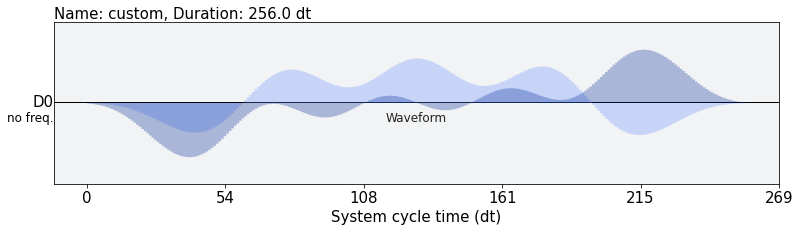

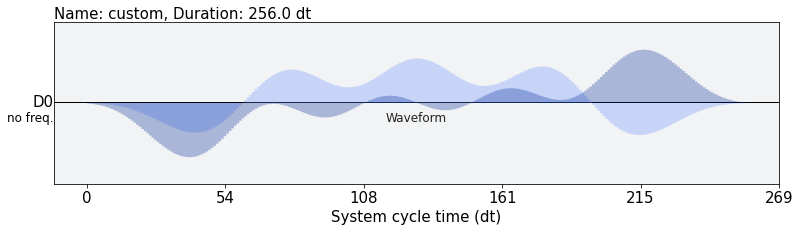

In [144]:
g_q0.draw()